In [133]:
import os
import datetime
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from base.logging import Logger

PROJECT = 'housing'
ENV = 'dev'
ID = f'{PROJECT}-{ENV}'

global log
log = Logger(ID)

In [135]:
from base.process import Process

No missing values


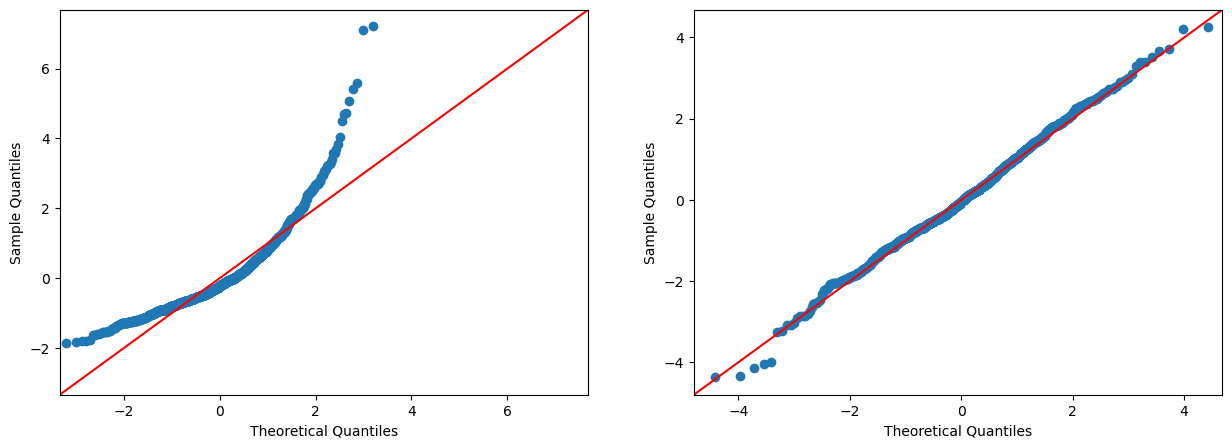

In [136]:
proc = Process()
proc.load()
proc.log()
proc.fill()
proc.scale()
proc.encode()
proc.feature_selection(grid=False)
#proc.pca()
proc.split()

In [173]:
from base.model import Model,MODELS

In [174]:
models = [
    Model(**{
        'x_train': proc.x_train,
        'y_train': proc.y_train,
        'x_test': proc.x_test,
        'y_test': proc.y_test,
        'x_predict': proc.x_predict,
        'run_grid': False,
        **m,
    })
    for m in MODELS
    if m['name'] not in [
        'ransac','mlp','svm',
        'sgd','lso','en','kr',
    ]
]

In [175]:
for model in models:
    model.run('test')
    model.run('main')
    model.eval()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/

In [176]:
meta = Model(**{
        'x_train': pd.concat([model.pred_train for model in models],axis=1),
        'y_train': models[0].y_train,
        'x_test': pd.concat([model.pred_test for model in models],axis=1),
        'y_test': models[0].y_test,
        'x_predict': pd.concat([model.pred_main for model in models],axis=1),
        'run_grid': False,
        'name': 'meta',
        'model': RandomForestRegressor,
        'params': None,
    })

meta.run('test')
meta.run('main')
meta.eval()

In [180]:
eval = pd.DataFrame([{'model': model.name,'mse': model.mse,'mae': model.mae,} for model in models+[meta]]).sort_values('mae')

<Axes: xlabel='model'>

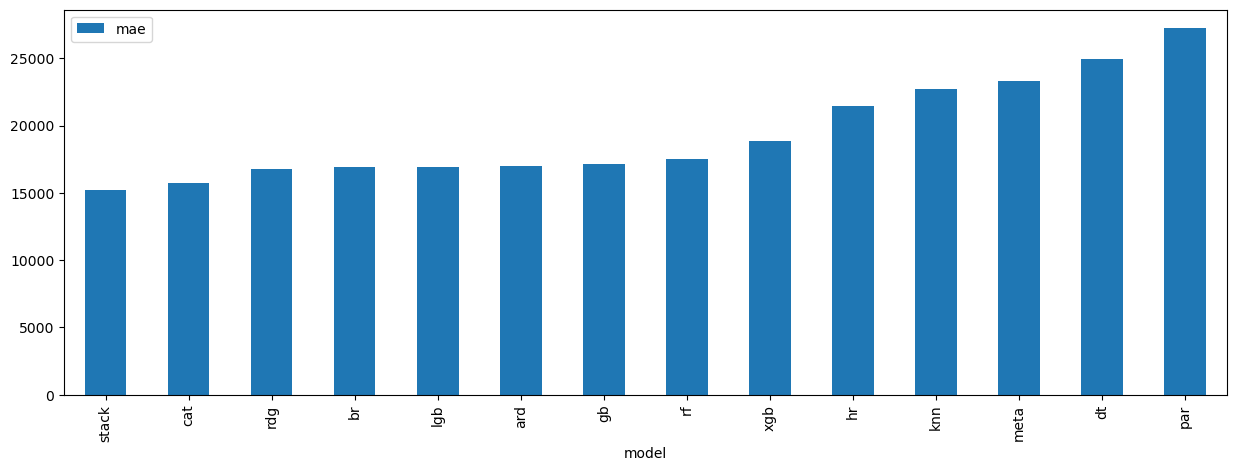

In [181]:
eval.plot(kind='bar',x='model',y=['mae'],figsize=(15,5))

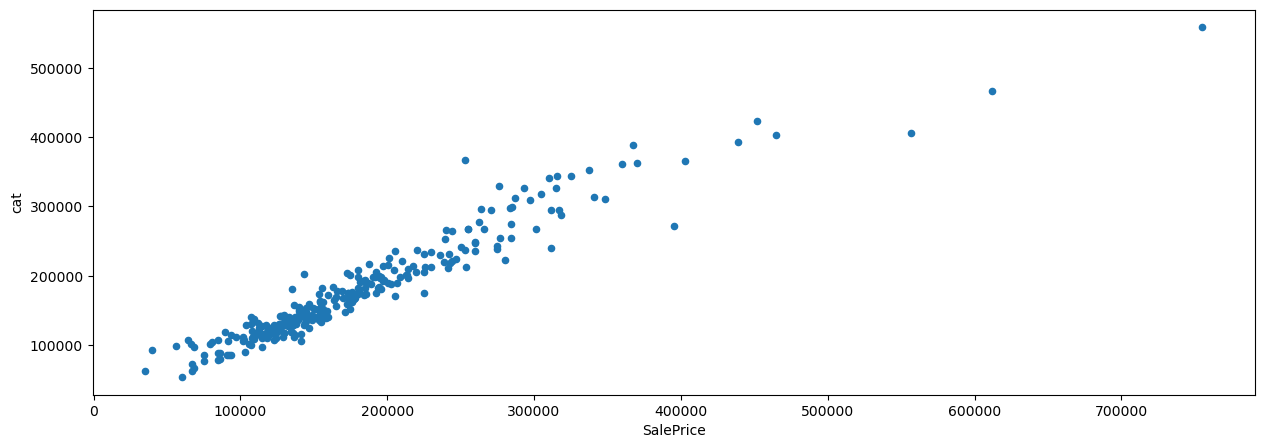

In [183]:
for model in models:
    if model.name=='cat':
        pd.concat([model.pred_test,np.exp(model.y_test)],axis=1).plot(kind='scatter',x='SalePrice',y=model.name,figsize=(15,5))
        model.pred_main.rename('SalePrice').to_csv(os.path.join('~','Downloads','pred.csv'),index=True)